In [1]:
import numpy as np
import math
import random
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as scio
import pprint as pp

from sklearn.svm import SVC

%matplotlib inline 

## Question 8 - SVM Implementation


### Part A


In [2]:
mat = scio.loadmat('HW2_Data/data1.mat')

X_trn = mat['X_trn']
Y_trn = mat['Y_trn']
X_tst = mat['X_tst']
Y_tst = mat['Y_tst']
data = [X_trn,Y_trn,X_tst,Y_tst]

In [3]:
print('shape of the X data is [%d, %d]' % X_trn.shape)
print('shape of the Y data is [%d, %d]' % Y_trn.shape)

shape of the X data is [136, 2]
shape of the Y data is [136, 1]


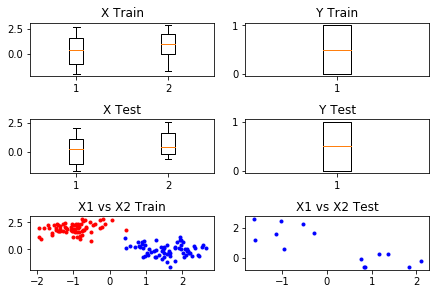

In [4]:
data_labels = ['X Train', 'Y Train', 'X Test', 'Y Test']

for x in range(4):
    plt.subplot(3,2,x +1)
    plt.boxplot(data[x])
    plt.title(data_labels[x])

# turn all 0s into -1    
Y_trn = np.mat(Y_trn).A1.astype(int)
for i in range(len(Y_trn)):
    if (Y_trn[i] == 0):
        Y_trn[i] = Y_trn[i] - 1
        
Y_tst = np.mat(Y_tst).A1.astype(int)
for i in range(len(Y_tst)):
    if (Y_tst[i] == 0):
        Y_tst[i] = - 1
X_trn = np.mat(X_trn).A
X_tst = np.mat(X_tst).A

X_1a = []
X_2a = []
X_1b = []
X_2b = []
for i in range(len(X_trn)):
    if (Y_trn[i] == 1):
        X_1a.append(X_trn[i][0])
        X_2a.append(X_trn[i][1])
    else:
        X_1b.append(X_trn[i][0])
        X_2b.append(X_trn[i][1])

X_1atst = []
X_2atst = []
X_1btst = []
X_2btst = []
for i in range(len(X_tst)):
    if (Y_tst[i] == 1):
        X_1atst.append(X_tst[i][0])
        X_2atst.append(X_tst[i][1])
    else:
        X_1btst.append(X_tst[i][0])
        X_2btst.append(X_tst[i][1])
    
plt.subplot(3,2,5)
plt.plot(X_1a, X_2a, 'b.')
plt.plot(X_1b, X_2b, 'r.')
plt.title("X1 vs X2 Train")

plt.subplot(3,2,6)
plt.plot(X_1atst, X_2atst, 'b.')
plt.plot(X_1btst, X_2btst, 'b.')
plt.title("X1 vs X2 Test")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [5]:
def kernelGen(X):
    K = []
    for i in range(len(X)):
        temp = []
        for j in range(len(X)):
            xi = np.mat(X[i])
            xj = np.mat(X[j])
            
            temp.append(np.dot(xi,xj.T).A)
        K.append(np.concatenate(temp).ravel().tolist())

    return K

In [6]:
def dualF(Y,K,j,b,alpha):
    E = 0
    for i in range(len(K)):
        innx = K[i][j]
        
        E += (alpha[i] * Y[i] * innx)
        
    E = E + b - Y[j]
    
    
    return E

In [7]:
def CostW(K,Y,A):
    W = 0
    for i in range(len(K)):
        W += A[i]
    
    temp = 0
    for i in range(len(K)):
        for j in range(len(K)):
            temp += Y[i]*Y[j]*A[i]*A[j]*K[i][j]
    W = W - (0.5 * temp)
    return W        

In [8]:
def simplifiedSMO(K,Y,c,tol,maxPass):
    alpha = np.zeros((len(K)))
    b = 0
    passes = 0
    while(passes < maxPass):
        num_changed_alphas = 0
        for i in range(len(K)):
            Ei = dualF(Y, K, i, b, alpha)
            temp = Ei * Y[i]
            
            if (((temp < (-1 * tol)) and (alpha[i] < c)) or ((temp > tol) and (alpha[i] > 0))):
                j = random.randint(0, len(K) -1)
                while (j == i):
                    j = random.randint(0, len(K) -1)
                    
                Ej = dualF(Y, K, j, b, alpha)
                # Save off old Alphas
                alOldi = alpha[i]
                alOldj = alpha[j]
                
                # Calculate L and H
                L = max(0, alpha[j] - alpha[i])
                H = min(c, c + alpha[j] - alpha[i])
                #print(str(L) + " " + str(H))
                
                if (L == H):
                    continue
                #calculate n (eta)
                
                n = (2* K[i][j]) - (K[i][i]) - (K[j][j])
                if (n >= 0):
                    continue
                
                #calculate new aj
                alNewj = alOldj - ((Y[j] * (Ei - Ej))/n)
                alNewj = np.clip(alNewj, 0, c)
                
                
                if (alNewj > H):
                    alNewj = H
                elif (alNewj < L):
                    alNewj = L
                
                if (abs(alNewj - alOldj) < 10**(-5)):
                    continue
                
                alNewi = alOldi + (Y[i] * Y[j] * (alOldj - alNewj))
                alNewi = np.clip(alNewi, 0, c)
                
                alpha[i] = alNewi
                alpha[j] = alNewj
                
                # calculate bs
                b1 = b - Ei - (Y[i] * (alpha[i] - alOldi) * K[i][i]) - (Y[j] * (alpha[j] - alOldj) * K[i][j])
                b2 = b - Ej - (Y[i] * (alpha[i] - alOldi) * K[i][j]) - (Y[j] * (alpha[j] - alOldj) * K[j][j])
                
                b = (b1 + b2)/2
                
                if ((0 < alpha[i]) and (alpha[i] < c)):
                    b = b1
                elif ((0 < alpha[j]) and (alpha[i] < c)):
                    b = b2
                
                num_changed_alphas += 1
                
                #w = CostW(K,Y,alpha)
                #print(w)
            #end if
        #end for
        if (num_changed_alphas == 0):
            passes += 1
        else:
            passes = 0
            
    return [alpha, b]

In [9]:
def errorF(Y, Ycomp):
    error = 0
    for i in range(len(Y)):
        if(Y[i] != Ycomp[i]):
            error += 1

    error = error / len(Y)  
    return error

### Part A Training

In [10]:
K = kernelGen(X_trn)
K = np.mat(K)
print('shape of the Kernel is [%d, %d]' % K.shape)
pp.pprint(K)

shape of the Kernel is [136, 136]
matrix([[ 4.21595296,  4.58430622,  4.74987417, ..., -1.78087801,
         -0.7723529 ,  0.87443262],
        [ 4.58430622,  5.03260949,  5.13914263, ..., -2.19740991,
         -1.30161751,  0.74835924],
        [ 4.74987417,  5.13914263,  5.36527708, ..., -1.86583566,
         -0.62138062,  1.09425604],
        ..., 
        [-1.78087801, -2.19740991, -1.86583566, ...,  2.17767455,
          2.84883698,  0.73668098],
        [-0.7723529 , -1.30161751, -0.62138062, ...,  2.84883698,
          4.60578532,  1.79722189],
        [ 0.87443262,  0.74835924,  1.09425604, ...,  0.73668098,
          1.79722189,  1.03961611]])


In [11]:
# Cross validated values
c = 0.5
tol = 10**(-5)
max_pass = 50


F = simplifiedSMO(K.A,Y_trn,c, tol, max_pass)

print("training completed")

training completed


training error:  0.0 %


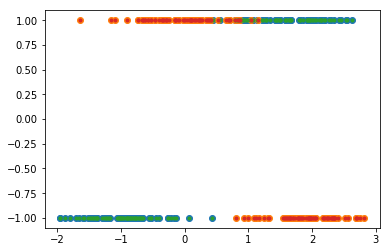

In [12]:

alpha = F[0]
b = F[1]

Wstar = 0
for i in range(len(K)):
    Wstar += alpha[i]*Y_trn[i]*X_trn[i]
    
w = np.mat(Wstar)
X = np.mat(X_trn).T

bias = np.mean(Y_trn - (w * X))

Y = np.sign((w * X) + bias)

plt.plot(X.T, Y.T, 'o')
plt.plot(X.T, Y_trn, '.')
error = errorF(Y.T, Y_trn)

print("training error: ", error * 100, "%")


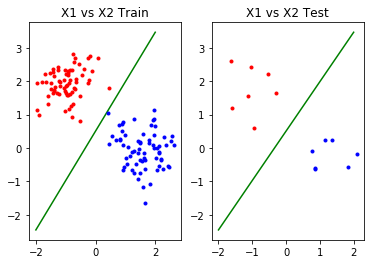

In [13]:
X1_line = np.mat([-2,-1,0,1,2]).T
X2_line = (X1_line * -1 * w.A1[0] - bias) / w.A1[1]

plt.subplot(1,2,1)
plt.plot(X1_line, X2_line, 'g-')
plt.plot(X_1a, X_2a, 'b.')
plt.plot(X_1b, X_2b, 'r.')
plt.title("X1 vs X2 Train")

plt.subplot(1,2,2)
plt.plot(X1_line, X2_line, 'g-')
plt.plot(X_1atst, X_2atst, 'b.')
plt.plot(X_1btst, X_2btst, 'r.')
plt.title("X1 vs X2 Test")

testing error:  0.0 %


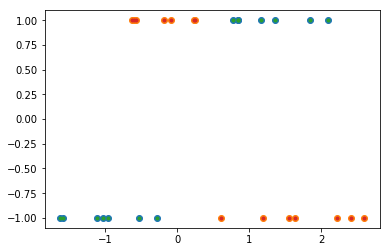

In [14]:
Xtst = np.mat(X_tst).T
Ytst = np.sign((w*Xtst) + bias)
plt.plot(Xtst.T, Ytst.T, 'o')
plt.plot(Xtst.T, Y_tst, '.')


error = errorF(Ytst.T, Y_tst)

print("testing error: ", error * 100, "%")

### Part B

In [15]:
mat = scio.loadmat('HW2_Data/data2.mat')

X_trn = mat['X_trn']
Y_trn = mat['Y_trn']
X_tst = mat['X_tst']
Y_tst = mat['Y_tst']
data = [X_trn,Y_trn,X_tst,Y_tst]

In [16]:
print('shape of the X data is [%d, %d]' % X_trn.shape)
print('shape of the Y data is [%d, %d]' % Y_trn.shape)

shape of the X data is [126, 2]
shape of the Y data is [126, 1]


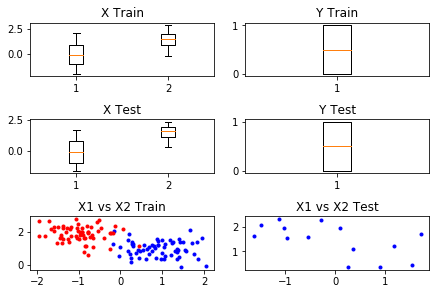

In [17]:
data_labels = ['X Train', 'Y Train', 'X Test', 'Y Test']

for x in range(4):
    plt.subplot(3,2,x +1)
    plt.boxplot(data[x])
    plt.title(data_labels[x])

# turn all 0s into -1    
Y_trn = np.mat(Y_trn).A1.astype(int)
for i in range(len(Y_trn)):
    if (Y_trn[i] == 0):
        Y_trn[i] = Y_trn[i] - 1
        
Y_tst = np.mat(Y_tst).A1.astype(int)
for i in range(len(Y_tst)):
    if (Y_tst[i] == 0):
        Y_tst[i] = - 1
X_trn = np.mat(X_trn).A
X_tst = np.mat(X_tst).A

X_1a = []
X_2a = []
X_1b = []
X_2b = []
for i in range(len(X_trn)):
    if (Y_trn[i] == 1):
        X_1a.append(X_trn[i][0])
        X_2a.append(X_trn[i][1])
    else:
        X_1b.append(X_trn[i][0])
        X_2b.append(X_trn[i][1])

X_1atst = []
X_2atst = []
X_1btst = []
X_2btst = []
for i in range(len(X_tst)):
    if (Y_tst[i] == 1):
        X_1atst.append(X_tst[i][0])
        X_2atst.append(X_tst[i][1])
    else:
        X_1btst.append(X_tst[i][0])
        X_2btst.append(X_tst[i][1])
    
plt.subplot(3,2,5)
plt.plot(X_1a, X_2a, 'b.')
plt.plot(X_1b, X_2b, 'r.')
plt.title("X1 vs X2 Train")

plt.subplot(3,2,6)
plt.plot(X_1atst, X_2atst, 'b.')
plt.plot(X_1btst, X_2btst, 'b.')
plt.title("X1 vs X2 Test")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### Part B Training

In [18]:
K = kernelGen(X_trn)
K = np.mat(K)
print('shape of the Kernel is [%d, %d]' % K.shape)
pp.pprint(K)

shape of the Kernel is [126, 126]
matrix([[ 3.8159644 ,  4.44544987,  4.57627588, ...,  2.31217578,
          2.78539384,  2.73911874],
        [ 4.44544987,  5.21939438,  5.30420419, ...,  2.41511969,
          2.81564555,  2.95933383],
        [ 4.57627588,  5.30420419,  5.50599503, ...,  2.95782908,
          3.62546523,  3.43872547],
        ..., 
        [ 2.31217578,  2.41511969,  2.95782908, ...,  3.31018646,
          4.63047467,  3.24773617],
        [ 2.78539384,  2.81564555,  3.62546523, ...,  4.63047467,
          6.56897025,  4.4471155 ],
        [ 2.73911874,  2.95933383,  3.43872547, ...,  3.24773617,
          4.4471155 ,  3.28707332]])


In [19]:
# Cross validated values
c = 0.5
tol = 10**(-5)
max_pass = 50


F = simplifiedSMO(K.A,Y_trn,c, tol, max_pass)

print("training completed")

training completed


training error:  3.968253968253968 %


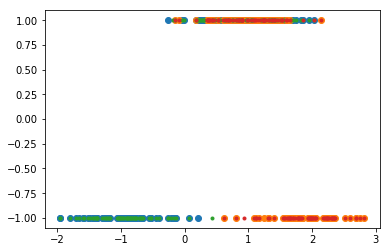

In [20]:

alpha = F[0]
b = F[1]

Wstar = 0
for i in range(len(K)):
    Wstar += alpha[i]*Y_trn[i]*X_trn[i]
    
w = np.mat(Wstar)
X = np.mat(X_trn).T

bias = np.mean(Y_trn - X.T*w.T)

Y = np.sign((w * X) + bias)

plt.plot(X.T, Y.T, 'o')
plt.plot(X.T, Y_trn, '.')
error = errorF(Y.T, Y_trn)

print("training error: ", error * 100, "%")


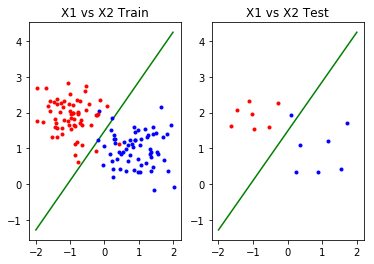

In [21]:
X1_line = np.mat([-2,-1,0,1,2]).T
X2_line = (X1_line * -1 * w.A1[0] - bias) / w.A1[1]

plt.subplot(1,2,1)
plt.plot(X1_line, X2_line, 'g-')
plt.plot(X_1a, X_2a, 'b.')
plt.plot(X_1b, X_2b, 'r.')
plt.title("X1 vs X2 Train")

plt.subplot(1,2,2)
plt.plot(X1_line, X2_line, 'g-')
plt.plot(X_1atst, X_2atst, 'b.')
plt.plot(X_1btst, X_2btst, 'r.')
plt.title("X1 vs X2 Test")

testing error:  7.142857142857142 %


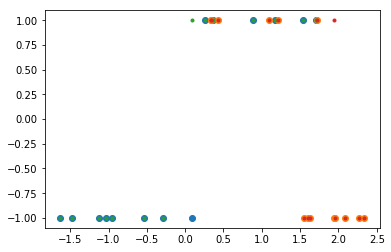

In [22]:
Xtst = np.mat(X_tst).T
Ytst = np.sign((w*Xtst) + bias)
plt.plot(Xtst.T, Ytst.T, 'o')
plt.plot(Xtst.T, Y_tst, '.')
error = errorF(Ytst.T, Y_tst)

print("testing error: ", error * 100, "%")

In data set 2 the data points are much closer together and are not linearly seperable.  That means that without a more robust (higher dimensional) Kernel, we will always have some error.

## SKLearn

I ran the second dataset through SKlearn's linear SVM algorithm and got the following:

In [24]:
clf = SVC()
Y_trn = np.mat(Y_trn)

clf.fit(X_trn, Y_trn.T.A1)
Y_sol = clf.predict(X_trn)
Y_soltst = clf.predict(X_tst)

training error:  3.1746031746031744 %


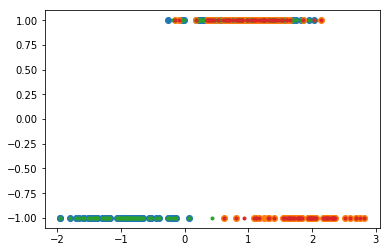

In [25]:
plt.plot(X_trn, Y_sol, 'o')
plt.plot(X_trn, Y_trn.T, '.')
error = errorF(Y_sol, Y_trn.T)

print("training error: ", error * 100, "%")

testing error:  7.142857142857142 %


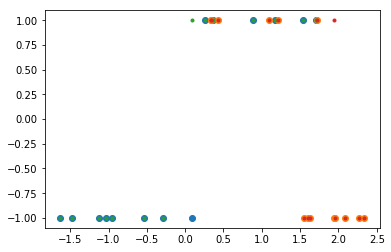

In [26]:
plt.plot(X_tst, Y_soltst, 'o')
plt.plot(X_tst, Y_tst.T, '.')
error = errorF(Y_soltst, Y_tst.T)

print("testing error: ", error * 100, "%")